In [1]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [2]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes

In [5]:
dataname = "m4_daily_domain"
dataset = utils.get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_daily_domain


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain/test/data.json


In [6]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [7]:
train_entry

{'start': Timestamp('1750-01-01 00:00:00', freq='D'),
 'target': array([1017.1, 1019.3, 1017. , ..., 2022.1, 2031.6, 2029.7], dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain/train/data.json'), line=1), row=1)}

### Plot Series

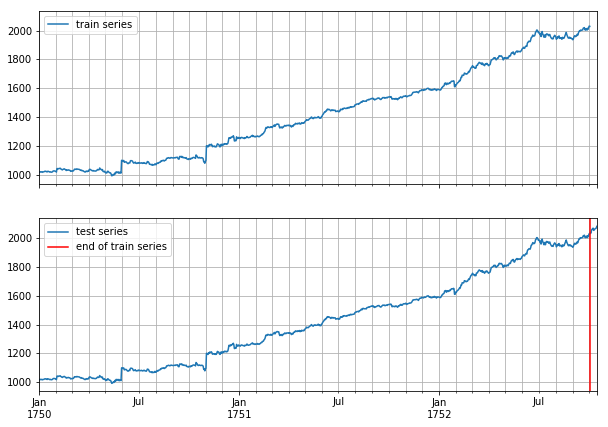

In [8]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

## DeepAR - with 2 static features

In [9]:
# gluonts
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

# DeepAREstimator
from gluonts.model.deepar import DeepAREstimator

INFO:root:Using CPU


In [16]:
dataset.metadata.feat_static_cat

[CategoricalFeatureInfo(name='series_id', cardinality='4227'),
 CategoricalFeatureInfo(name='domain', cardinality='6')]

In [17]:
[feat_static_cat.cardinality for feat_static_cat in dataset.metadata.feat_static_cat]

['4227', '6']

In [18]:
######################
### deepar wrapper ###
def deepar(data="m4_quarterly", seed=42, epochs=100, batches=50):

    dataset = get_dataset(data, regenerate=False)
    mx.random.seed(seed)
    np.random.seed(seed)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=batches,
        learning_rate=1e-3,
    )
    
    estimator = DeepAREstimator(
        trainer=trainer,
        cardinality= [
            feat_static_cat.cardinality 
            for feat_static_cat in dataset.metadata.feat_static_cat
        ],
        context_length=dataset.metadata.prediction_length,
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True
    )

    # predictor = estimator.train(training_data=dataset.train,
    #                             validation_data=dataset.test)
    predictor = estimator.train(training_data=dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
        dataset.test, predictor=predictor, num_samples=100
    )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = batches

    df = pd.DataFrame([output])

    return df


In [55]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_weekly_domain", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.03it/s, avg_epoch_loss=7.25]
INFO:root:Epoch[0] Elapsed time 14.273 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.249107
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.75it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 12.919 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.842752
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 12.833 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.715181
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.16it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[3] Elapsed time 13.982 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[72] Elapsed time 13.239 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.694953
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.40it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 13.523 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.739723
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:13<00:00,  7.62it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 13.131 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.727140
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[75] Elapsed time 12.839 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.697670
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:14<00:00,  7.01it/s, avg_epoch_

       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.647697  0.086228  23.8142            0.063018            0.026098    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 17.111 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.347654
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.74it/s, avg_epoch_loss=6.73]
INFO:root:Epoch[1] Elapsed time 14.844 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.731935
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.43it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 15.560 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617084
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.02it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 12.471 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:13<00:00,  7.62it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 13.137 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.739076
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:14<00:00,  7.09it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 14.116 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.702046
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  7.94it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[74] Elapsed time 12.600 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.712714
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:18<00:00,  5.44it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 18.394 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.689485
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:16<00:00,  6.21it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 16.111

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.623139  0.078814  25.410871            0.058675            0.027255   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.87it/s, avg_epoch_loss=7.28]
INFO:root:Epoch[0] Elapsed time 14.564 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.278435
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.60it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 13.165 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.902134
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.18it/s, avg_epoch_loss=6.8]
INFO:root:Epoch[2] Elapsed time 16.214 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.797005
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.05it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 16.537 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.85it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[72] Elapsed time 12.748 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.698361
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  7.95it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[73] Elapsed time 12.583 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.813056
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 12.048 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.758513
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 12.022 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.714763
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.427714  0.080337  21.225715            0.058028            0.027024   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.56it/s, avg_epoch_loss=7.61]
INFO:root:Epoch[0] Elapsed time 13.237 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.609840
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.26it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 12.109 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.858014
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.25it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[2] Elapsed time 12.128 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.593339
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.27it/s, avg_epoch_loss=6.5]
INFO:root:Epoch[3] Elapsed time 13.769 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[72] Elapsed time 11.798 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.724213
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.94it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 11.190 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.736934
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.32it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[74] Elapsed time 12.029 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.719512
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.11it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 12.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.758608
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.61it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 11.614 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.731946
INFO

       MASE     sMAPE     MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.532896  0.082743  22.5323            0.061719            0.027687    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:26<00:00,  3.81it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 26.285 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.185408
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:21<00:00,  4.69it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 22.016 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.828843
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.85it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[2] Elapsed time 17.090 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.635259
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:19<00:00,  5.18it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[3] Elapsed time 19.327 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Learning rate is 0.00025
100%|██████████| 100/100 [00:17<00:00,  5.81it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[72] Elapsed time 17.219 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.780194
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.07it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 19.739 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.706591
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.46it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 15.487 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.727589
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:15<00:00,  6.44it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[75] Elapsed time 15.528 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.755305
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:19<00:00,  5.21it/s, avg_epoch

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.555657  0.080359  20.955645            0.059487            0.027132   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.85it/s, avg_epoch_loss=7.3]
INFO:root:Epoch[0] Elapsed time 12.750 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.304906
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.02it/s, avg_epoch_loss=6.81]
INFO:root:Epoch[1] Elapsed time 16.609 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.811662
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:23<00:00,  4.23it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 23.662 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.671203
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.70it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 14.940 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

INFO:root:Epoch[36] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.99it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[36] Elapsed time 11.134 seconds
INFO:root:Epoch[36] Evaluation metric 'epoch_loss'=5.868941
INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.12it/s, avg_epoch_loss=5.87]
INFO:root:Epoch[37] Elapsed time 14.047 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.868302
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.53it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[38] Elapsed time 15.324 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.816277
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:17<00:00,  5.77it/s, avg_epoch_loss=5.86]
INFO:root:Epoch[39] Elapsed time 17.348 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.855502
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.30it/s, avg_epoch_loss=5.82

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.974403  0.085861  25.400273            0.062869            0.027911   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.55it/s, avg_epoch_loss=7.48]
INFO:root:Epoch[0] Elapsed time 15.280 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.478983
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.93it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 14.440 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.849439
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.37it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 13.575 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.621795
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.38it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 13.560 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:12<00:00,  7.71it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 12.972 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.740380
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.50it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 13.341 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.711495
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 12.467 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.772928
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  7.99it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 12.520 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.710616
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.54it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[76] Elapsed time 13.26

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.688655  0.078402  23.730044            0.058814            0.026328   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.06it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 16.499 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.274832
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.84it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 12.758 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.901552
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.18it/s, avg_epoch_loss=6.64]
INFO:root:Epoch[2] Elapsed time 12.233 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.640127
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.58]
INFO:root:Epoch[3] Elapsed time 12.418 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss

100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[72] Elapsed time 12.462 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.745766
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:13<00:00,  7.33it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 13.656 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.750547
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:14<00:00,  6.96it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 14.374 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.732204
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 12.046 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.726268
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.03it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 12.4

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.877221  0.088606  27.282367            0.064581            0.029408   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.80it/s, avg_epoch_loss=7.23]
INFO:root:Epoch[0] Elapsed time 12.827 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.228729
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.19it/s, avg_epoch_loss=6.84]
INFO:root:Epoch[1] Elapsed time 12.215 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.835405
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.23it/s, avg_epoch_loss=6.74]
INFO:root:Epoch[2] Elapsed time 12.155 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.737825
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.05it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[3] Elapsed time 14.201 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

INFO:root:Epoch[72] Elapsed time 14.986 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.816377
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.27it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[73] Elapsed time 12.107 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.771947
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.65it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 13.079 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.725435
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  7.79it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[75] Elapsed time 12.838 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.749768
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.01it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[76] Elapsed time 12.491 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.744976
INFO

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.921541  0.082299  35.811205            0.062046            0.031452   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  6.77it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 14.784 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.214874
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.58it/s, avg_epoch_loss=6.77]
INFO:root:Epoch[1] Elapsed time 13.193 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.766113
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.08it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 12.378 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.616317
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[3] Elapsed time 12.407 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_los

100%|██████████| 100/100 [00:12<00:00,  8.21it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[72] Elapsed time 12.190 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.742276
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.25it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[73] Elapsed time 12.126 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.726250
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.20it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[74] Elapsed time 12.200 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.687006
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.11it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[75] Elapsed time 12.338 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.660340
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:12<00:00,  8.24it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 12.1

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.896752  0.082645  27.99451            0.062774            0.027616    51   

   epochs  num_batches  
0     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.647697,0.086228,23.814200,0.063018,0.026098,42,100,100
0,2.623139,0.078814,25.410871,0.058675,0.027255,43,100,100
0,2.427714,0.080337,21.225715,0.058028,0.027024,44,100,100
0,2.532896,0.082743,22.532300,0.061719,0.027687,45,100,100
0,2.555657,0.080359,20.955645,0.059487,0.027132,46,100,100
0,2.974403,0.085861,25.400273,0.062869,0.027911,47,100,100
0,2.688655,0.078402,23.730044,0.058814,0.026328,48,100,100
0,2.877221,0.088606,27.282367,0.064581,0.029408,49,100,100
0,2.921541,0.082299,35.811205,0.062046,0.031452,50,100,100
0,2.896752,0.082645,27.994510,0.062774,0.027616,51,100,100


In [56]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_weekly", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

Seed: 42


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.07it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 12.400 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.333318
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:14<00:00,  7.14it/s, avg_epoch_loss=6.83]
INFO:root:Epoch[1] Elapsed time 14.011 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.825292
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.31it/s, avg_epoch_loss=6.71]
INFO:root:Epoch[2] Elapsed time 12.038 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.714820
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:11<00:00,  8.41it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 11.897 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.723969
INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:12<00:00,  8.06it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[73] Elapsed time 12.410 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.720925
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.44it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[74] Elapsed time 13.449 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.746610
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:15<00:00,  6.48it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[75] Elapsed time 15.443 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.713437
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:16<00:00,  6.17it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[76] Elapsed time 16.214 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.730055
INFO:root:Epoch[77] Learning rate is 0.001
100%|████

       MASE    sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.675979  0.08395  29.957781            0.062653            0.031221    42   

   epochs  num_batches  
0     100          100  
Seed: 43


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:56<00:00,  1.77it/s, avg_epoch_loss=7.66]
INFO:root:Epoch[0] Elapsed time 56.605 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.661190
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:44<00:00,  2.25it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 44.491 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.848373
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:30<00:00,  3.33it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 30.095 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.670903
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [01:06<00:00,  1.50it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 66.898 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.54

INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.774737
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 100/100 [00:29<00:00,  3.36it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[78] Elapsed time 29.818 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=5.755154
INFO:root:Loading parameters from best epoch (68)
INFO:root:Epoch[79] Learning rate is 0.0005
100%|██████████| 100/100 [00:32<00:00,  3.10it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[79] Elapsed time 32.275 seconds
INFO:root:Epoch[79] Evaluation metric 'epoch_loss'=5.725712
INFO:root:Epoch[80] Learning rate is 0.0005
100%|██████████| 100/100 [00:25<00:00,  3.98it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[80] Elapsed time 25.112 seconds
INFO:root:Epoch[80] Evaluation metric 'epoch_loss'=5.722851
INFO:root:Epoch[81] Learning rate is 0.0005
100%|██████████| 100/100 [00:28<00:00,  3.56it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[81] Elapsed time 28.113 seconds
INFO:root:Epoch[81] Evaluation metric 'epoch_loss'=5.708067

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.685703  0.083277  28.105718            0.061119            0.028726   

   seed  epochs  num_batches  
0    43     100          100  
Seed: 44


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:24<00:00,  4.11it/s, avg_epoch_loss=7.86]
INFO:root:Epoch[0] Elapsed time 24.335 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.855830
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.48it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[1] Elapsed time 22.314 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.882931
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.39it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 22.776 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.653240
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:22<00:00,  4.47it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 22.391 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.41

INFO:root:Epoch[72] Elapsed time 7.066 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.672958
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 14.02it/s, avg_epoch_loss=5.81]
INFO:root:Epoch[73] Elapsed time 7.139 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.809516
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 13.96it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 7.173 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.735798
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 12.69it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 7.888 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.694645
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:07<00:00, 14.16it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 7.067 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.745840
I

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  2.553431  0.085053  22.71406            0.061923            0.028575    44   

   epochs  num_batches  
0     100          100  
Seed: 45


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.61it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 7.355 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.407360
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.98it/s, avg_epoch_loss=6.79]
INFO:root:Epoch[1] Elapsed time 7.157 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.794106
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.27it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 7.016 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.622933
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.26it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[3] Elapsed time 7.017 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.543541

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.14it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 7.077 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.695781
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.33it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 6.984 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.764650
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.32it/s, avg_epoch_loss=5.78]
INFO:root:Epoch[75] Elapsed time 7.518 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.778142
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 11.50it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[76] Elapsed time 8.708 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.746556
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.35it/s, avg_epoch_loss=5.77]
INF

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.551216  0.083366  23.017125            0.061141            0.026905   

   seed  epochs  num_batches  
0    45     100          100  
Seed: 46


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.00it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 7.152 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.326514
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.81it/s, avg_epoch_loss=6.85]
INFO:root:Epoch[1] Elapsed time 7.248 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.853384
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.31it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 6.992 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.617557
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[3] Elapsed time 6.951 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.553704

100%|██████████| 100/100 [00:08<00:00, 11.13it/s, avg_epoch_loss=5.79]
INFO:root:Epoch[72] Elapsed time 9.000 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.788570
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.40it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[73] Elapsed time 6.951 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.714600
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 6.857 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.737887
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.42it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[75] Elapsed time 6.942 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.770974
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.43it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[76] Elapsed time 6.93

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.480305  0.092277  21.864018             0.06577            0.027685   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.86it/s, avg_epoch_loss=7.31]
INFO:root:Epoch[0] Elapsed time 7.226 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.307405
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.18it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 7.596 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.824542
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:08<00:00, 12.30it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 8.141 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.645937
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.44it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 6.929 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.514965

INFO:root:Epoch[72] Elapsed time 6.922 seconds
INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.744076
INFO:root:Epoch[73] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.65it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 6.830 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.741253
INFO:root:Epoch[74] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.51it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[74] Elapsed time 6.898 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.766386
INFO:root:Epoch[75] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.84it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 6.746 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.730355
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.000125
100%|██████████| 100/100 [00:06<00:00, 14.82it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[76] Elapsed time 6.752 seconds
INFO:root:

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.749931  0.083731  28.312247            0.060692            0.027068   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.18it/s, avg_epoch_loss=7.43]
INFO:root:Epoch[0] Elapsed time 7.059 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.429280
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.85it/s, avg_epoch_loss=6.82]
INFO:root:Epoch[1] Elapsed time 6.740 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.820354
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.68it/s, avg_epoch_loss=6.67]
INFO:root:Epoch[2] Elapsed time 6.817 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.670751
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.88it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 6.727 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.511574

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.721156
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 13.94it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[73] Elapsed time 7.177 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.703478
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[74] Elapsed time 6.855 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.756778
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.60it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[75] Elapsed time 6.856 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.689615
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.59it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[76] Elapsed time 6.860 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.692570
INFO:root:Epoch[77] Learning rate is 0.0005
100%|████

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.700239  0.085821  27.460034            0.063158            0.029634   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.27it/s, avg_epoch_loss=7.45]
INFO:root:Epoch[0] Elapsed time 7.013 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.449640
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.13it/s, avg_epoch_loss=6.9]
INFO:root:Epoch[1] Elapsed time 7.083 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.897352
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 15.04it/s, avg_epoch_loss=6.62]
INFO:root:Epoch[2] Elapsed time 6.655 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.623805
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.22it/s, avg_epoch_loss=6.45]
INFO:root:Epoch[3] Elapsed time 7.041 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.452351


INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.722645
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.89it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[73] Elapsed time 6.721 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.746408
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.81it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[74] Elapsed time 6.759 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.741140
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 15.01it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[75] Elapsed time 6.669 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.728174
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:07<00:00, 14.21it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[76] Elapsed time 7.045 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.710951
INFO:root:Epoch[77] Learning rate is 0.0005
100%|███

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.152744  0.099731  36.241247            0.072664            0.036317   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.32it/s, avg_epoch_loss=7.35]
INFO:root:Epoch[0] Elapsed time 6.992 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.352016
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.63it/s, avg_epoch_loss=6.86]
INFO:root:Epoch[1] Elapsed time 6.842 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.862839
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.46it/s, avg_epoch_loss=6.72]
INFO:root:Epoch[2] Elapsed time 6.921 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.723205
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.80it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[3] Elapsed time 6.762 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.574496

INFO:root:Epoch[72] Evaluation metric 'epoch_loss'=5.784105
INFO:root:Epoch[73] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.95it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[73] Elapsed time 6.692 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.768236
INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.88it/s, avg_epoch_loss=5.73]
INFO:root:Epoch[74] Elapsed time 6.727 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.734738
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:06<00:00, 14.85it/s, avg_epoch_loss=5.75]
INFO:root:Epoch[75] Elapsed time 6.740 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.749332
INFO:root:Loading parameters from best epoch (65)
INFO:root:Epoch[76] Learning rate is 0.00025
100%|██████████| 100/100 [00:06<00:00, 14.79it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[76] Elapsed time 6.768 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.759117
I

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.551079  0.086004  22.716032            0.061955            0.025813   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:using dataset already processed in path C:\Users\TM\.mxnet\gluon-ts\datasets\m4_weekly.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.11it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 10.991 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.317519
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:13<00:00,  7.66it/s, avg_epoch_loss=6.88]
INFO:root:Epoch[1] Elapsed time 13.063 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.879192
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.95it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[2] Elapsed time 10.060 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.654424
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:10<00:00,  9.61it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[3] Elapsed time 10.408 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.51

INFO:root:Epoch[73] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.29it/s, avg_epoch_loss=5.74]
INFO:root:Epoch[73] Elapsed time 7.005 seconds
INFO:root:Epoch[73] Evaluation metric 'epoch_loss'=5.742055
INFO:root:Epoch[74] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 13.84it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[74] Elapsed time 7.237 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.718351
INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.35it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[75] Elapsed time 6.976 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.668933
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 100/100 [00:06<00:00, 14.34it/s, avg_epoch_loss=5.72]
INFO:root:Epoch[76] Elapsed time 6.978 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.721582
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 100/100 [00:07<00:00, 14.23it/s, avg_epoch_loss=5.72]
IN

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  2.938536  0.088076  26.387251            0.067153            0.030391   

   seed  epochs  num_batches  
0    51     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,2.675979,0.083950,29.957781,0.062653,0.031221,42,100,100
0,2.685703,0.083277,28.105718,0.061119,0.028726,43,100,100
0,2.553431,0.085053,22.714060,0.061923,0.028575,44,100,100
0,2.551216,0.083366,23.017125,0.061141,0.026905,45,100,100
0,2.480305,0.092277,21.864018,0.065770,0.027685,46,100,100
0,2.749931,0.083731,28.312247,0.060692,0.027068,47,100,100
0,2.700239,0.085821,27.460034,0.063158,0.029634,48,100,100
0,3.152744,0.099731,36.241247,0.072664,0.036317,49,100,100
0,2.551079,0.086004,22.716032,0.061955,0.025813,50,100,100
0,2.938536,0.088076,26.387251,0.067153,0.030391,51,100,100


### m4_daily vs. m4_daily domain

- reload `utils`
- test `m4_daily` vs. `m4_daily_domain`
- ten trials each, 
 - `epochs=100`, `num_batches_per_epoch=100`

In [14]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily_domain", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[0] Elapsed time 5.021 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.361301
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[1] Elapsed time 5.216 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.597530
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.26it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.194 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.524238
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.22it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 4.947 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.69it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:05<00:00, 19.83it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.046 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.581159
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.26it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 4.939 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.581405
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 5.063 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.559741
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.34it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 4.920 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.515251
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.06it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 4.987 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.92it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 5.025 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.405126
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[75] Elapsed time 5.038 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.415121
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[76] Elapsed time 5.125 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.447603
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.58it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 4.861 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.398449
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.42

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.810611  0.035636  46.457133            0.032933            0.015265   

   seed  epochs  num_batches  
0    42     100          100  
Seed: 43


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.75it/s, avg_epoch_loss=7.26]
INFO:root:Epoch[0] Elapsed time 4.600 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.264834
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.18it/s, avg_epoch_loss=6.65]
INFO:root:Epoch[1] Elapsed time 5.216 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.645659
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.01it/s, avg_epoch_loss=6.57]
INFO:root:Epoch[2] Elapsed time 5.262 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.565277
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.19it/s, avg_epoch_loss=6.42]
INFO:root:Epoch[3] Elapsed time 4.955 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.419175
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.65]
INFO:root:Epoch[37] Elapsed time 5.079 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.652452
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[38] Elapsed time 5.109 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.597433
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.43it/s, avg_epoch_loss=5.76]
INFO:root:Epoch[39] Elapsed time 5.148 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.762333
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.70it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[40] Elapsed time 5.078 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.629700
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.84it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[41] Elapsed time 5.045 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[74] Elapsed time 5.057 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.518309
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.78it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[75] Elapsed time 5.327 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.554678
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.05it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[76] Elapsed time 4.990 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.517119
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[77] Elapsed time 5.059 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.589703
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  4.686141  0.041681  69.08875            0.038529            0.021287    43   

   epochs  num_batches  
0     100          100  
Seed: 44


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:05<00:00, 19.93it/s, avg_epoch_loss=7.27]
INFO:root:Epoch[0] Elapsed time 5.021 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.271277
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.55it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[1] Elapsed time 5.393 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.555693
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.08it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 5.244 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.525706
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.48it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 5.413 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.409730
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.93it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.84]
INFO:root:Epoch[37] Elapsed time 5.135 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.838069
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[38] Elapsed time 5.135 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.694697
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss=5.77]
INFO:root:Epoch[39] Elapsed time 5.103 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.772262
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.96it/s, avg_epoch_loss=5.7]
INFO:root:Epoch[40] Elapsed time 5.012 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.695577
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.38it/s, avg_epoch_loss=5.69]
INFO:root:Epoch[41] Elapsed time 5.162 seconds

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.648795  0.034095  44.136896            0.029586            0.013566   

   seed  epochs  num_batches  
0    44     100          100  
Seed: 45


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.07it/s, avg_epoch_loss=7.21]
INFO:root:Epoch[0] Elapsed time 4.749 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.206096
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.46it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[1] Elapsed time 5.139 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.525294
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.30it/s, avg_epoch_loss=6.53]
INFO:root:Epoch[2] Elapsed time 5.182 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.527155
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.65it/s, avg_epoch_loss=6.33]
INFO:root:Epoch[3] Elapsed time 5.092 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.329723
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss

100%|██████████| 100/100 [00:04<00:00, 20.07it/s, avg_epoch_loss=5.67]
INFO:root:Epoch[37] Elapsed time 4.985 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.667390
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.28it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[38] Elapsed time 5.190 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.594586
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.81it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[39] Elapsed time 5.048 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.621434
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.52it/s, avg_epoch_loss=5.82]
INFO:root:Epoch[40] Elapsed time 5.126 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.819597
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.85it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[41] Elapsed time 5.041 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[74] Elapsed time 5.030 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.498212
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=5.51]
INFO:root:Epoch[75] Elapsed time 5.148 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.507902
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 5.135 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.503682
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.54it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[77] Elapsed time 5.122 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.565621
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 10

      MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.86877  0.035711  53.745233             0.03318            0.016892    45   

   epochs  num_batches  
0     100          100  
Seed: 46


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 20.86it/s, avg_epoch_loss=7.08]
INFO:root:Epoch[0] Elapsed time 4.797 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.075297
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.32it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 5.177 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.549395
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.206 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.517536
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.02it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 4.995 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.343182
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.65it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.133 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.584953
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.16it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[38] Elapsed time 4.963 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.552912
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.67it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[39] Elapsed time 5.358 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.565469
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.11it/s, avg_epoch_loss=5.57]
INFO:root:Epoch[40] Elapsed time 5.235 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.573756
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.139 second

100%|██████████| 100/100 [00:05<00:00, 19.06it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[74] Elapsed time 5.247 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.446005
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.67it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[75] Elapsed time 5.661 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.449589
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.50it/s, avg_epoch_loss=5.49]
INFO:root:Epoch[76] Elapsed time 5.131 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.492294
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.86it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[77] Elapsed time 5.036 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.430829
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.38]
INFO:root:Epoch[78] Elapsed time 5.065 se

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.486731  0.033482  41.862445            0.028125            0.013472   

   seed  epochs  num_batches  
0    46     100          100  
Seed: 47


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.03it/s, avg_epoch_loss=7.33]
INFO:root:Epoch[0] Elapsed time 4.757 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.327109
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=6.59]
INFO:root:Epoch[1] Elapsed time 5.146 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.588857
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.73it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[2] Elapsed time 5.071 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.512587
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=6.41]
INFO:root:Epoch[3] Elapsed time 5.028 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.407704
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.60it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.17it/s, avg_epoch_loss=5.71]
INFO:root:Epoch[37] Elapsed time 5.218 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.714732
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[38] Elapsed time 5.109 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.617921
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.34it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 5.172 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.657180
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.27it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[40] Elapsed time 4.935 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.616374
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[41] Elapsed time 5.133 seconds

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 20.00it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[74] Elapsed time 5.004 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.457822
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[75] Elapsed time 5.084 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.468463
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.40it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[76] Elapsed time 5.158 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.461796
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.09it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[77] Elapsed time 5.241 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.504532
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 1

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.536524  0.033463  45.310314            0.027968            0.013934   

   seed  epochs  num_batches  
0    47     100          100  
Seed: 48


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.25it/s, avg_epoch_loss=7.32]
INFO:root:Epoch[0] Elapsed time 4.709 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.315512
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.45it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[1] Elapsed time 5.143 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.508927
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 5.088 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.489106
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 5.061 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.355872
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.55it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[37] Elapsed time 5.068 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.625750
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.14it/s, avg_epoch_loss=5.63]
INFO:root:Epoch[38] Elapsed time 4.969 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.630708
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[39] Elapsed time 5.209 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.594367
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.30it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[40] Elapsed time 4.929 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.594264
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.57it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[41] Elapsed time 5.113 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[74] Elapsed time 5.091 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.437903
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.01it/s, avg_epoch_loss=5.43]
INFO:root:Epoch[75] Elapsed time 4.998 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.433098
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.49it/s, avg_epoch_loss=5.48]
INFO:root:Epoch[76] Elapsed time 5.135 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.479101
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.75it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[77] Elapsed time 5.065 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.454463
INFO:root:Loading parameters from best epoch (67)
INFO:root:Epoch[78] Learning rate is 0.00025
100%|██████████| 

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.490511  0.032395  44.574563            0.028979            0.014046   

   seed  epochs  num_batches  
0    48     100          100  
Seed: 49


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.04it/s, avg_epoch_loss=7.15]
INFO:root:Epoch[0] Elapsed time 4.755 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.152857
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.85it/s, avg_epoch_loss=6.54]
INFO:root:Epoch[1] Elapsed time 5.306 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.538895
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.58it/s, avg_epoch_loss=6.46]
INFO:root:Epoch[2] Elapsed time 5.109 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.456689
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.98it/s, avg_epoch_loss=6.34]
INFO:root:Epoch[3] Elapsed time 5.007 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.342433
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=5.62]
INFO:root:Epoch[37] Elapsed time 5.209 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.622880
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.27it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[38] Elapsed time 5.191 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.676320
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[39] Elapsed time 5.268 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.662803
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.39it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[40] Elapsed time 5.159 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.554064
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.47it/s, avg_epoch_loss=5.59]
INFO:root:Epoch[41] Elapsed time 5.137 second

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.424077  0.032263  40.660041            0.027711            0.013049   

   seed  epochs  num_batches  
0    49     100          100  
Seed: 50


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.44it/s, avg_epoch_loss=7.41]
INFO:root:Epoch[0] Elapsed time 4.667 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.412522
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.66it/s, avg_epoch_loss=6.55]
INFO:root:Epoch[1] Elapsed time 5.089 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.545913
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 17.53it/s, avg_epoch_loss=6.49]
INFO:root:Epoch[2] Elapsed time 5.704 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.488928
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.12it/s, avg_epoch_loss=6.36]
INFO:root:Epoch[3] Elapsed time 4.973 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.364336
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.79it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 17.60it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[37] Elapsed time 5.683 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.546698
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:04<00:00, 20.04it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 4.991 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.583882
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[39] Elapsed time 5.082 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.603402
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=5.55]
INFO:root:Epoch[40] Elapsed time 5.026 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.547070
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.53]
INFO:root:Epoch[41] Elapsed time 5.117 seconds

100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 5.031 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.414473
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[75] Elapsed time 5.122 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.411675
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.5]
INFO:root:Epoch[76] Elapsed time 5.165 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.496363
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:04<00:00, 20.26it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[77] Elapsed time 4.939 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.469821
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.77it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[78] Elapsed time 5.064 sec

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  3.779968  0.035661  46.922437            0.032369            0.015249   

   seed  epochs  num_batches  
0    50     100          100  
Seed: 51


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:04<00:00, 21.27it/s, avg_epoch_loss=7.19]
INFO:root:Epoch[0] Elapsed time 4.705 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.193942
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=6.56]
INFO:root:Epoch[1] Elapsed time 5.027 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.564774
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.00it/s, avg_epoch_loss=6.51]
INFO:root:Epoch[2] Elapsed time 5.264 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.510698
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.90it/s, avg_epoch_loss=6.38]
INFO:root:Epoch[3] Elapsed time 5.026 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.378963
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.53it/s, avg_epoch_loss

100%|██████████| 100/100 [00:05<00:00, 19.71it/s, avg_epoch_loss=5.66]
INFO:root:Epoch[37] Elapsed time 5.076 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.663865
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.93it/s, avg_epoch_loss=5.68]
INFO:root:Epoch[38] Elapsed time 5.020 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.678267
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.78it/s, avg_epoch_loss=5.64]
INFO:root:Epoch[39] Elapsed time 5.060 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.637952
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.91it/s, avg_epoch_loss=5.6]
INFO:root:Epoch[40] Elapsed time 5.026 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.599013
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.167 seconds

       MASE     sMAPE      MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  seed  \
0  3.398746  0.032219  43.94735            0.027842            0.013395    51   

   epochs  num_batches  
0     100          100  


,MASE,sMAPE,MSIS,wQuantileLoss[0.5],wQuantileLoss[0.9],seed,epochs,num_batches
0,3.810611,0.035636,46.457133,0.032933,0.015265,42,100,100
0,4.686141,0.041681,69.088750,0.038529,0.021287,43,100,100
0,3.648795,0.034095,44.136896,0.029586,0.013566,44,100,100
0,3.868770,0.035711,53.745233,0.033180,0.016892,45,100,100
0,3.486731,0.033482,41.862445,0.028125,0.013472,46,100,100
0,3.536524,0.033463,45.310314,0.027968,0.013934,47,100,100
0,3.490511,0.032395,44.574563,0.028979,0.014046,48,100,100
0,3.424077,0.032263,40.660041,0.027711,0.013049,49,100,100
0,3.779968,0.035661,46.922437,0.032369,0.015249,50,100,100
0,3.398746,0.032219,43.947350,0.027842,0.013395,51,100,100


In [19]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily_domain", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results

INFO:root:using dataset already processed in path /home/ec2-user/.mxnet/gluon-ts/datasets/m4_daily_domain.
INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/100 [00:00<?, ?it/s]

Seed: 42


INFO:root:Number of parameters in DeepARTrainingNetwork: 245571
100%|██████████| 100/100 [00:05<00:00, 19.89it/s, avg_epoch_loss=7.36]
INFO:root:Epoch[0] Elapsed time 5.031 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=7.361301
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 18.78it/s, avg_epoch_loss=6.6]
INFO:root:Epoch[1] Elapsed time 5.325 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=6.597530
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.06it/s, avg_epoch_loss=6.52]
INFO:root:Epoch[2] Elapsed time 5.248 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=6.524238
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.82it/s, avg_epoch_loss=6.39]
INFO:root:Epoch[3] Elapsed time 5.047 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=6.389166
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.37it/s, avg_epoch_loss=

100%|██████████| 100/100 [00:05<00:00, 19.22it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[37] Elapsed time 5.205 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=5.581159
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.56it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[38] Elapsed time 5.113 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=5.581405
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.11it/s, avg_epoch_loss=5.56]
INFO:root:Epoch[39] Elapsed time 5.236 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=5.559741
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.64it/s, avg_epoch_loss=5.52]
INFO:root:Epoch[40] Elapsed time 5.096 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=5.515251
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 100/100 [00:05<00:00, 19.36it/s, avg_epoch_loss=5.58]
INFO:root:Epoch[41] Elapsed time 5.167 second

INFO:root:Epoch[74] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=5.41]
INFO:root:Epoch[74] Elapsed time 5.268 seconds
INFO:root:Epoch[74] Evaluation metric 'epoch_loss'=5.405126
INFO:root:Epoch[75] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.48it/s, avg_epoch_loss=5.42]
INFO:root:Epoch[75] Elapsed time 5.135 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=5.415121
INFO:root:Epoch[76] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 19.00it/s, avg_epoch_loss=5.45]
INFO:root:Epoch[76] Elapsed time 5.265 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=5.447603
INFO:root:Epoch[77] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 17.33it/s, avg_epoch_loss=5.4]
INFO:root:Epoch[77] Elapsed time 5.774 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=5.398449
INFO:root:Epoch[78] Learning rate is 0.0005
100%|██████████| 100/100 [00:05<00:00, 18.84it/s, avg_epoch_loss=5.42

INFO:root:Epoch[110] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.68it/s, avg_epoch_loss=5.44]
INFO:root:Epoch[110] Elapsed time 5.083 seconds
INFO:root:Epoch[110] Evaluation metric 'epoch_loss'=5.442785
INFO:root:Epoch[111] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 18.87it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[111] Elapsed time 5.302 seconds
INFO:root:Epoch[111] Evaluation metric 'epoch_loss'=5.391728
INFO:root:Epoch[112] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 17.54it/s, avg_epoch_loss=5.39]
INFO:root:Epoch[112] Elapsed time 5.703 seconds
INFO:root:Epoch[112] Evaluation metric 'epoch_loss'=5.387038
INFO:root:Epoch[113] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.20it/s, avg_epoch_loss=5.47]
INFO:root:Epoch[113] Elapsed time 5.211 seconds
INFO:root:Epoch[113] Evaluation metric 'epoch_loss'=5.466813
INFO:root:Epoch[114] Learning rate is 6.25e-05
100%|██████████| 100/100 [00:05<00:00, 19.82i

INFO:root:Epoch[183] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.21it/s, avg_epoch_loss=5.46]
INFO:root:Epoch[183] Elapsed time 5.209 seconds
INFO:root:Epoch[183] Evaluation metric 'epoch_loss'=5.456849
INFO:root:Epoch[184] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.99it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[184] Elapsed time 5.268 seconds
INFO:root:Epoch[184] Evaluation metric 'epoch_loss'=5.373388
INFO:root:Epoch[185] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 18.53it/s, avg_epoch_loss=5.37]
INFO:root:Epoch[185] Elapsed time 5.401 seconds
INFO:root:Epoch[185] Evaluation metric 'epoch_loss'=5.366395
INFO:root:Epoch[186] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.55it/s, avg_epoch_loss=5.36]
INFO:root:Epoch[186] Elapsed time 5.117 seconds
INFO:root:Epoch[186] Evaluation metric 'epoch_loss'=5.360771
INFO:root:Epoch[187] Learning rate is 5e-05
100%|██████████| 100/100 [00:05<00:00, 19.05it/s, avg_epoch_

GluonTSDataError: Could not read json line 3283, {"start":"1750-01-01 00:00:00","target":[18787.2,18787.7,18035.2,18405,18794.6,18665.7,18974,18589.5,18416.2,18703,18512.8,18460.7,18630.1,18598.4,18561,18259.4,18372.5,18493.8,18766.1,18878.8,18845,18888.6,18797.9,18478.6,18292,18288.3,18166.4,17913.6,18461.5,18377.2,18193.4,18168.1,18249.9,18114.5,18047.8,18057.5,17997.2,17977.4,18039.6,17794.5,17705.9,17580.6,17588,17569.5,17711.2,18092.1,17917.6,17249.4,17814.5,17594,17537.2,17599.3,17614.7,17367.4,17583,17557.1,17366.3,17506.4,17742.8,17763.7,17569.8,17454.9,17565.8,17767.7,18116.8,17926.3,17838.3,17822.9,18025,17944.7,17851.1,17596.4,17669.1,17723.7,17685,17689.2,17825.6,17622.6,17781,17728.2,17395.1,17434,17569.3,17772.1,18046.9,18227.5,18114.8,18069.6,18084.6,18348.7,18245.9,18389.4,18421.7,18682.4,18805.6,18909.7,18931,18675.1,18685,18739.8,18692.6,18598.8,18728.8,18698.8,18380.9,18621.4,18247.6,18127.6,17535,16880.3,16065.3,15858.4,15784.7,14344.1,14614.7,14374.4,13314.3,12513.8,13476.3,14107.9,14471.4,14917.9,15325.1,14943.3,15177.7,15270.1,15571.3,15571.2,15427.2,15463.7,15928.4,16195.1,15976.6,14957.8,15327.1,15623.4,15410.7,15059.7,15442,15711.6,16116.8,15904.4,16405.9,16132.7,15760,15629.8,16137.5,16010,16530.1,16392.8,16922.6,17301.7,16950.2,16399.3,16597.6,16149.5,15736.6,15846.2,16121.2,15983.8,15839.2,16053.6,15900.4,15536.5,15357.9,15571.7,15758.2,15514.2,15455.9,15980.4,16162.8,16160.9,15787.1,15693.7,15439.1,15214.3,15012.3,15562.8,15229.9,15203.5,15110.1,15259.2,15102.4,15182.6,15656.7,15703.3,15877.2,16044.4,16235.6,15910.1,15730.4,15593.2,15551.1,15500.8,15512.6,15042.9,14978.4,14851.2,15339.3,15335.7,15266.5,15330.9,15459.5,15159.3,15096.2,14922.9,14587.8,14620.2,14412.7,14221.4,13922.9,13593,14084.6,14301.5,14565.2,14398.5,14472.8,14773.8,14503.2,13940.9,13833.5,13927.3,13754,13977.8,14049.9,14034.6,14478.1,14493.8,15058.7,15078.3,15206.8,15263.8,15395.4,15337.5,15159.1,15030,15293,15798.6,15961.6,16162.8,15827.8,15742,15539.2,15461.3,15730.2,15565.5,15712.7,15916,15740.4,15604.6,15575.2,15520.6,15173.4,15364.1,15737.4,15552.9,15632.2,15716.9,15836.5,15946,15775.6,15758.7,15577.6,15557,15470.5,15162.5,15044.2,14972.4,15047.4,15052.6,14732.9,14792.8,14867.4,14651.8,14863.5,14780.4,14561.7,14659.5,14713.8,14864.8,14835.7,14810,14628.4,14472,14297.9,14227.7,14398.2,14458.4,14439.9,14128.2,14044.7,13913.5,13499.4,13500.7,13677.7,13430.4,13422.2,13489.6,13067.8,12919.3,12575.7,13110.5,12908.5,12853.7,12404.1,12455,12076.3,12332.7,12270.3,12556.8,13411.3,13221.2,12588.4,12262.3,13275.1,13402.1,13252.4,12494.2,11987.6,12068.6,11477.4,11586.6,12093,12069.6,11318.9,10359.7,9585.7,9342.5,9972.8,10119.9,10986.2,11005.3,10699.6,10061.8,9896.9,9280.1,9662.2,9508.4,10109.1,10420.3,10118.4,10210.5,9891.8,10197.3,10319.9,11000.8,10750.4,11025.4,11288.3,10998.1,10740.4,11261.5,10606.4,10205.9,10337.9,9656.6,9683.2,9497.8,9814.3,9537.5,9737.6,9978.5,9415,8862.1,8593.3,8256.3,7728.3,7626.1,7646.9,7098.4,7117.1,7213.9,7623.1,7435.9,7006.5,7236.3,7673.6,7475.4,6940.7,7032.5,6934.9,6883,7294.5,7983.4,7883.1,8735.3,8633.2,8785.4,8846.8,8950.4,8820,8185.1,8439.4,8391.1,8789,8338.6,8553.4,8739.6,8563.1,9019,9418.2,9238.5,8769.2,8644.6,8382.7,8320.4,8164,8668.9,8877.5,9215.9,9121.3,9084.9,9510,9718.7,9734,9293.4,9643.8,9711.6,9700.6,9331.3,9302.1,9062,9092.9,8629.3,8832.8,9101.3,8968.3,8871.1,9228.5,9035.1,8796.3,8434.4,8559.2,8644.1,8648.4,8729.5,8352,8489.6,8534.9,8952.8,9004.8,9011.7,8758.7,8501.2,8756.6,8821.4,8850.7,8959.6,8791.8,8760.1,8409,8062,7830.8,7829.9,7762.1,7331.7,7334,7290.7,7466.6,7431.3,7620.6,7241.6,7493.1,7251.3,7075.3,6838.7,7150.2,6986.3,7049.3,7452.1,7809.8,7551.2,7356.3,7465.7,7158.3,6717.1,6511.2,6665.7,6909.4,7021.6,6690.5,6616.9,6259,6005.1,5648,5692.9,5341.8,5828.4,6358.9,6625.5,6406.5,6393.8,6116.6,6565.9,6162.9,6357,6141.2,5941.9,5863.8,5461.3,5600.2,5890.2,5957.7,5969.8,6486.4,6440.3,6381.7,6310,6306.2,6467.9,6871,7005.2,7025.3,7013.3,7130.9,7348.6,7103.1,6955,7326.3,7273.2,7398.6,7408.1,7363.5,7535.5,7725.6,7626.2,7291.3,7325.5,7395.1,7361,7281,7344.5,7416.7,6984.3,6801.1,6605.6,6926.1,6777.1,6946.9,7109.2,7156.2,7220.8,7448.1,7344,7473.6,7388,7633.8,7519,7626,7796.4,8019.8,7726.7,7986.7,8033,8003.1,7787.1,7863.6,7524.8,7597,7585.9,7492,7435.5,7350.8,7226.8,7349.9,7335.3,7563,7732.8,7778.9,7661.9,7817.6,8104.5,8284,8321.5,8119.8,8337.3,8230.5,8307.9,8233.3,8486.8,8347.8,8573.6,8622.9,8730,8899.9,8736.2,8668.4,8759.7,8542.2,8363,8339.7,8324.1,8495.3,8456.1,8629.1,8580.6,8660.6,8682.8,8664.7,8698.5,8589.1,8465.4,8243.4,8401.2,8264.6,8204.1,8432.6,8543.7,8612.4,8590.9,8815.2,8711.5,8561,8569.4,8501.9,8515.7,8503.8,8585.5,8667.5,8553.5,8312.9,8209.7,8033.7,7959.6,7845.1,7901.1,7789.3,7956.6,7948.4,8230,8125.9,8051.3,8064.3,8289.2,8184.2,8304.1,8312.7,8394.1,8355.3,8261,8423,8459.9,8199.4,8161,8149.8,8238,8304.9,8464.7,8665,8686.9,8969.2,8912.2,8811.2,8760.2,8874.7,8799.5,8750.2,8806.9,8864.7,8938.5,8705.9,8643.7,8632.8,8533.6,8583,8764.3,8620.3,8714.6,8785.9,8901.6,8957.2,9111.7,9100.8,9046.6,8968.1,9009,8982.5,9065.1,9166.9,9219.1,9328.9,9300.7,9416.7,9587.6,9517.3,9504.5,9420.7,9414,9528.4,9497.4,9597.7,9657.1,9719.2,9766.7,9693,9685.9,9762,9642.5,9642.9,9961.8,10195.5,10233.9,10221.2,10407.4,10509.7,10676.6,10417,10454.1,10624.9,10204.2,10108.5,10334.9,10252,10107.1,10190,10285.4,10521,10558.6,10422.9,10572.5,10363.1,10508.9,10600,10652.4,10457.8,10489.9,10289.2,10185,10146.1,10077,10095.4,10130,9889.4,9978.2,10084.2,10044.8,9988.7,9759.3,9389.9,9447.6,9116.5,9243.7,9377.6,9194.6,9167.7,9001.5,8919.9,8829.5,9059.9,8959.2,9059.6,8985.8,9001.6,9214.2,9423,9382,9310.2,9316.2,9341.9,9369,9349.3,9353.5,9326.8,9509.5,9469,9575.4,9476.3,9473.4,9544.6,9453.8,9503.1,9458.8,9326.2,9306.7,9276.8,9328.4,9538,9277,9099.6,8862.9,8899.5,8690.7,8876.1,8789.9,8786.3,8821.6,8990.9,8796.2,8883.5,8892.8,8956.3,9048,9166.8,9130.6,9052.8,9094.3,9119.1,9202.5,9378.1,9377.8,9256.1,9294.6,9224.9,9246.8,9267.8,9274.6,9331.8,9325.7,9159.2,9185.9,9283,9307.6,9492.8,9390.1,9301.9,9276.7,9258.3,9058.4,9002.2,9050.4,9059.9,8999.1

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=100, batches=100)
    pprint(df)
    results = results.append(df)

results

In [ ]:
results = pd.DataFrame()

for i in range(42, 52):
    print("Seed:", i)
    df = deepar(data="m4_daily", seed=i, epochs=200, batches=100)
    pprint(df)
    results = results.append(df)

results